In [152]:
import xml.etree.ElementTree as ET
import pandas as pd
import difflib
import string
import time

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from difflib import SequenceMatcher

import matplotlib.pyplot as plt
from matplotlib.table import Table

## Read and extract XSD elements

In [155]:
tag_meaning = {}
with open('TagsMeaning.txt', 'r', encoding='utf-8') as file:
    for line in file:
        if '==>' in line:
            tag, meaning = line.strip().split('==>')
            tag_meaning[tag.strip()] = meaning.strip()

In [157]:
def preprocess_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.lower().split()

def extract_tags(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    tags = {elem.tag for elem in root.iter()}
    return tags

def extract_xsd_elements(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    xsd_elements = []
    for element in root.iter('{http://www.w3.org/2001/XMLSchema}simpleType'):
        xsd_elements.append(element.attrib['name'])
    return xsd_elements

## Fuzzy Matching

In [160]:
def find_best_match(tag, meaning, xsd_elements):
    combined_text = " ".join(preprocess_text(tag) + preprocess_text(meaning))
    best_match, score = process.extractOne(combined_text, xsd_elements, scorer=fuzz.token_sort_ratio)
    return best_match, score

## Pairing data

In [163]:
def match_tags_with_xsd(tag_meaning, xsd_elements):
    matches = []
    for tag, meaning in tag_meaning.items():
        best_match, score = find_best_match(tag.strip(), meaning.strip(), xsd_elements)
        matches.append((tag, meaning, (best_match, score)))
    return matches

## Compare xml files

In [166]:
def calculate_similarity(tags1, tags2, tag_meaning):
    comparison_results = []
    for tag1 in tags1:
        best_match = None
        highest_similarity = 0
        meaning1 = tag_meaning.get(tag1, "Unknown")
        
        for tag2 in tags2:
            meaning2 = tag_meaning.get(tag2, "Unknown")
            similarity = SequenceMatcher(None, tag1, tag2).ratio()
            meaning_similarity = SequenceMatcher(None, meaning1, meaning2).ratio()
            combined_similarity = (similarity + meaning_similarity) / 2  # Weighted average
            
            if combined_similarity > highest_similarity:
                highest_similarity = combined_similarity
                best_match = tag2
        
        comparison_results.append({
            "Tag from File 1": tag1,
            "Meaning File 1": meaning1,
            "Best Match in File 2": best_match,
            "Meaning File 2": tag_meaning.get(best_match, "Unknown"),
            "Similarity Score": round(highest_similarity * 100, 2),
        })
    
    return pd.DataFrame(comparison_results)

def compute_overall_similarity(df):
    return df["Similarity Score"].mean()

def plot_similarity_scores(df):
    plt.figure(figsize=(10, 6))
    plt.barh(df["Tag from File 1"], df["Similarity Score"], color='blue', edgecolor='black')
    plt.xlabel("Similarity Score (%)")
    plt.ylabel("Tags from File 1")
    plt.title("Tag Similarity Scores Between Two XML Files")
    plt.tight_layout()
    plt.show()

## Plot results

In [169]:
def save_matches_to_csv(matches, output_file):

    data = [
        {
            "Tag": tag,
            "Meaning": meaning,
            "Best Match (XSD Element)": match[0] if match else "No Match",
            "Similarity (%)": f"{match[1]:.2f}%" if match else "0.00%"
        }
        for tag, meaning, match in matches
    ]
    

    df = pd.DataFrame(data)
    df['Similarity (%)'] = df['Similarity (%)'].str.rstrip('%').astype(float)  # Convert percentages to numeric for sorting
    sorted_df = df.sort_values(by="Similarity (%)", ascending=False)
    
    sorted_df.to_csv(output_file, index=False)
    
    print(f"Matches saved to '{output_file}' successfully.")


In [171]:
xml_file1 = "IPC-2581C.xsd"
xml_file2 = "test_1.xml"

tags_file1 = extract_tags(xml_file1)
tags_file2 = extract_tags(xml_file2)
elements_file1 = extract_xsd_elements(xml_file1)

Execution time overall similarity: 0.010782480239868164 seconds
Overall Similarity Score: 57.31%
Matches saved to 'fuzzy_matches_output.csv' successfully.
Execution time fuzzy matches: 0.5234329700469971 seconds


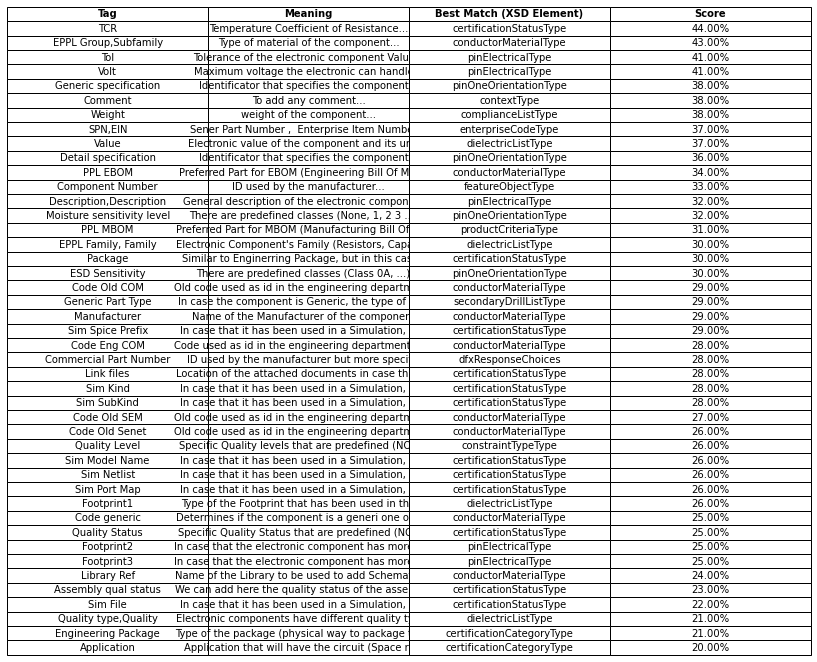

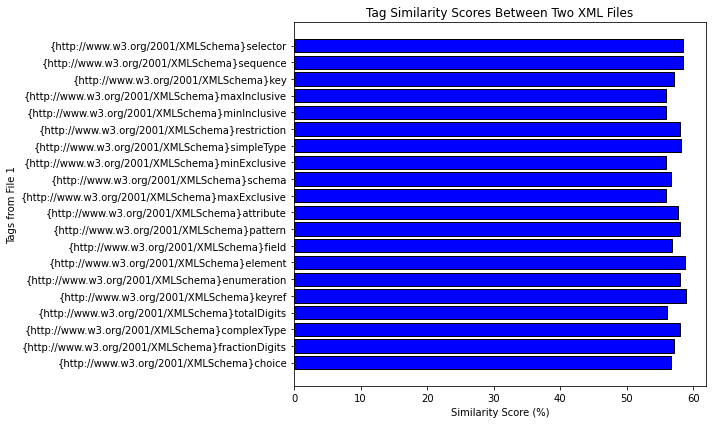

In [173]:
start_time = time.time()

comparison_df = calculate_similarity(tags_file1, tags_file2, tag_meaning)
overall_similarity = compute_overall_similarity(comparison_df)

end_time = time.time()
print(f"Execution time overall similarity: {end_time - start_time} seconds")
print(f"Overall Similarity Score: {round(overall_similarity, 2)}%")


start_time = time.time()

matches = match_tags_with_xsd(tag_meaning, elements_file1)
output_file = 'fuzzy_matches_output.csv'
save_matches_to_csv(matches, output_file)

end_time = time.time()
print(f"Execution time fuzzy matches: {end_time - start_time} seconds")

plot_table_with_matplotlib(matches)
plot_similarity_scores(comparison_df)